# Prediction of Score in Soccer Games

## 1. Loading DataFrames into pandas:

In [356]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [357]:
df=pd.read_csv('spi_matches.csv')


## 2. Data Cleaning & EDA:

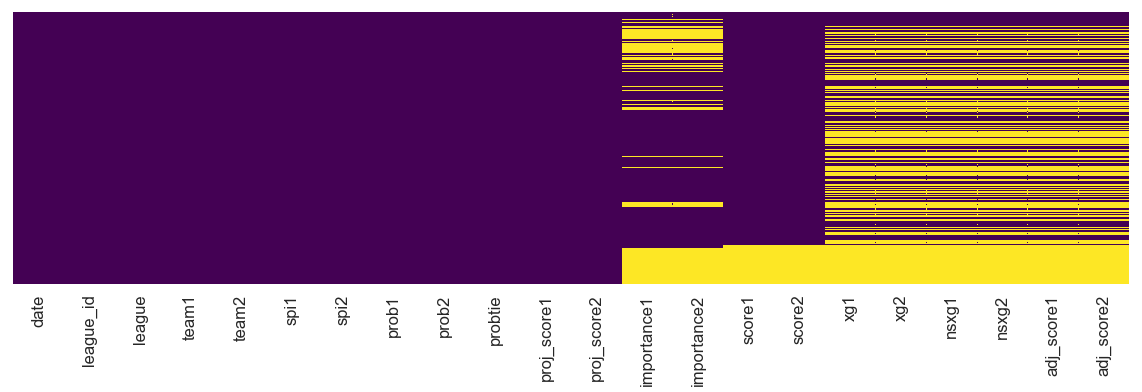

In [358]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis',)

We can see alot of missing values(yellow entries in the data). Since we are going to use linear regression so its better to 
remove all the null values as situation gets pretty messed up otherwise. Even if we manage to some how fill the data.Most of those will be treated as outliers and going away anyways

Below we will look at the data with respect to some ordinal variables like leagues and teams for EDA.

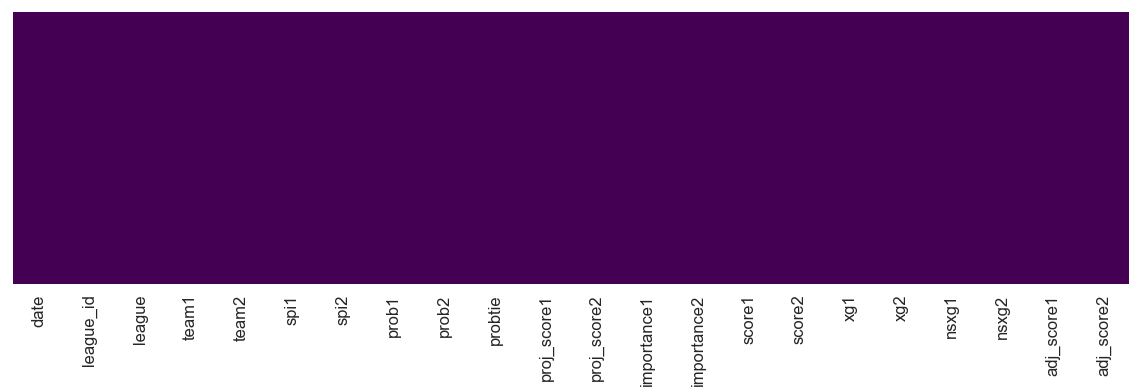

In [359]:
df=df.dropna().reset_index(drop=True)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis',)

## 3. Feature Engineering & EDA

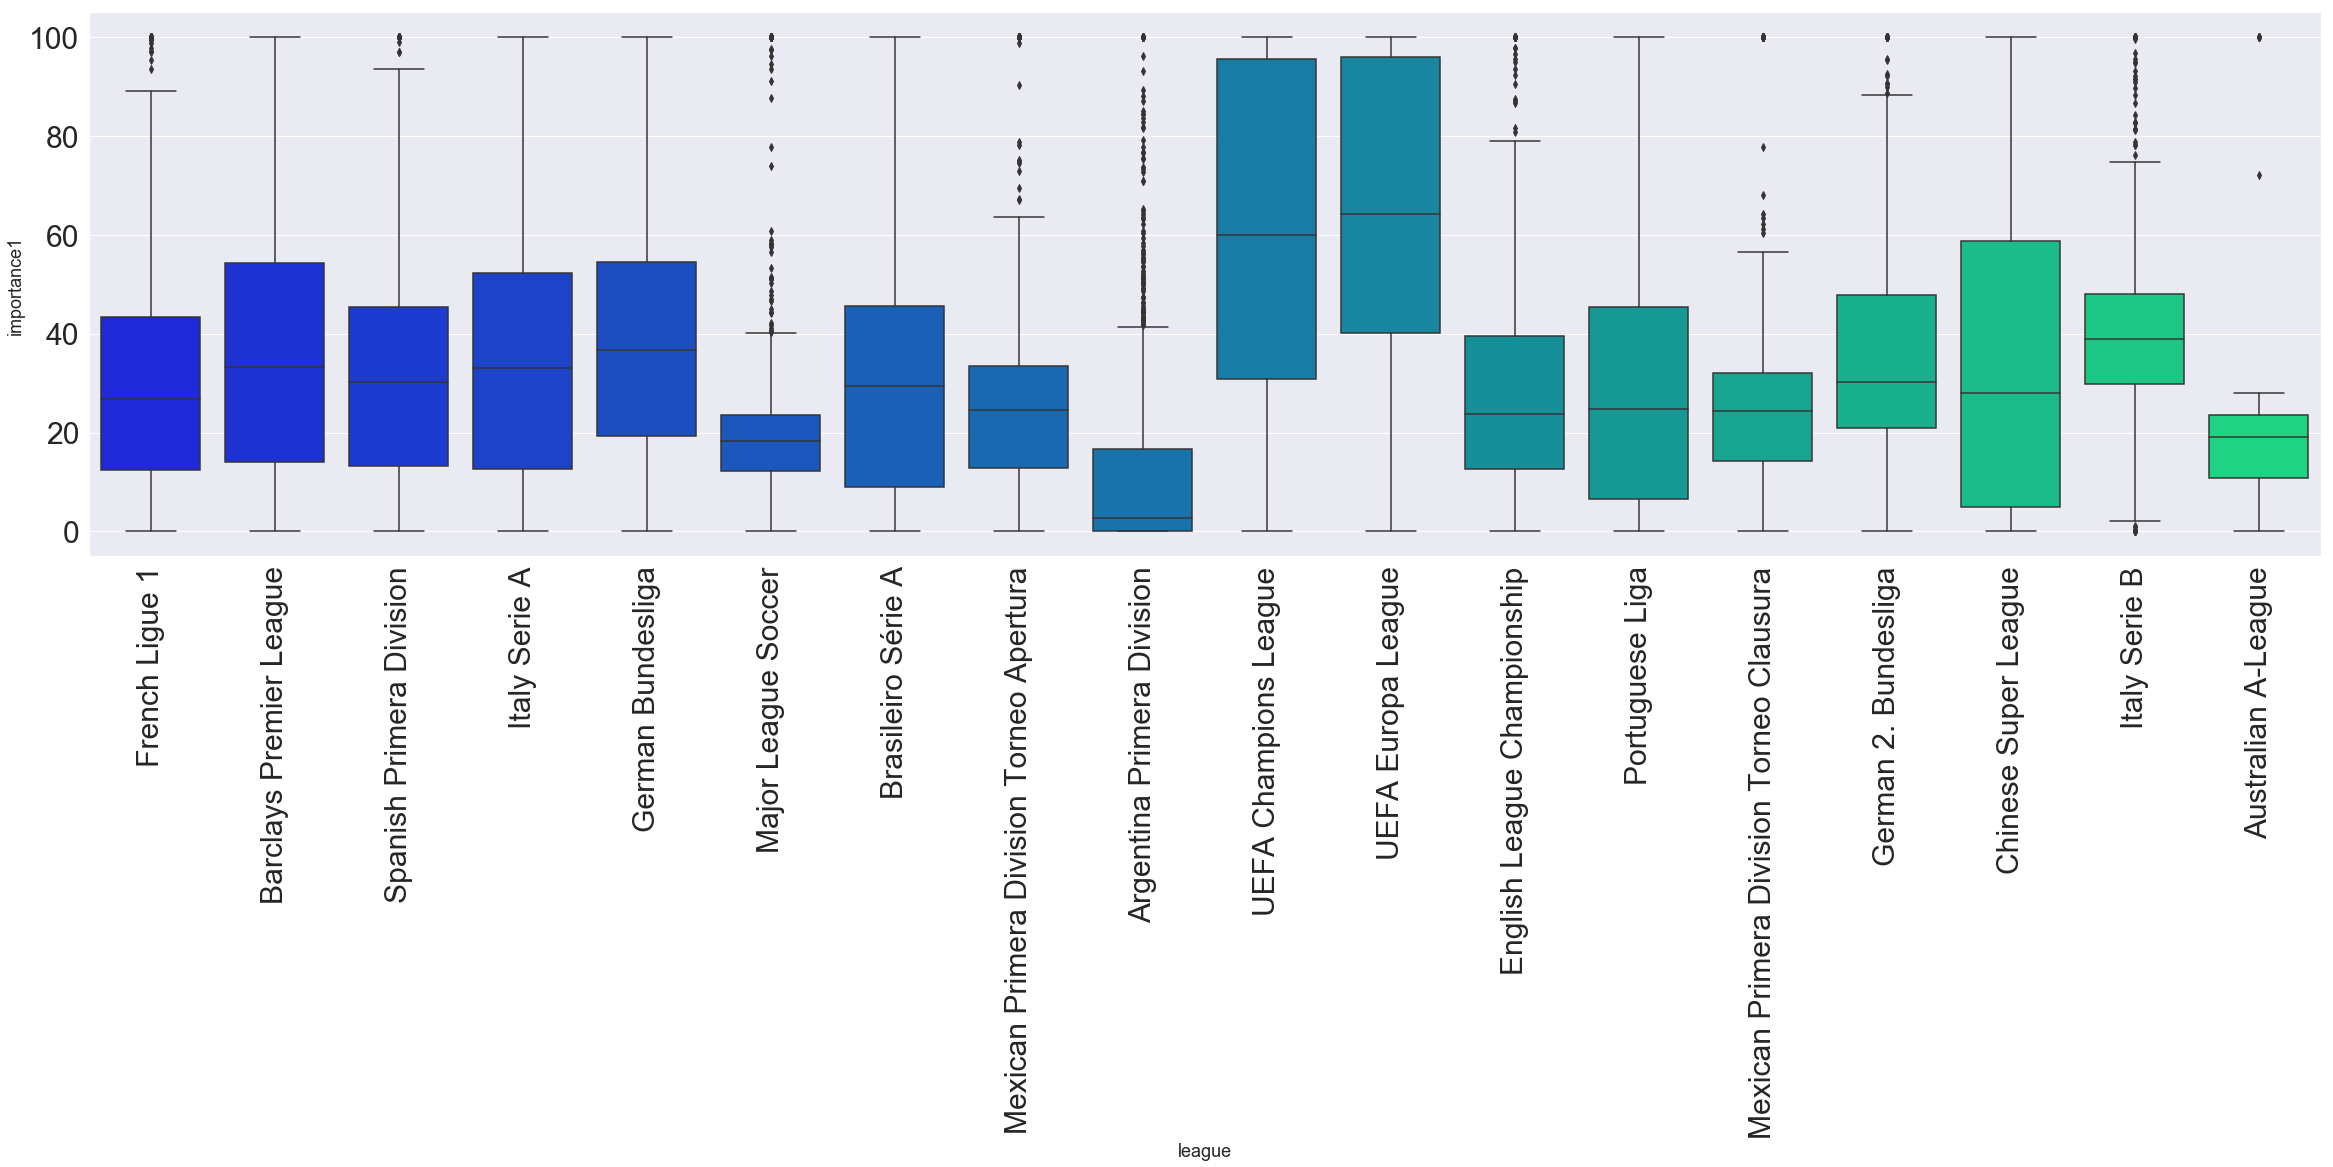

In [360]:
plt.figure(figsize=(40,10))
plt.xticks(size='30',rotation='vertical')
plt.yticks(size='30')
sns.boxplot(x='league',y='importance1',data=df,palette='winter',)

This box plot shows that each match in UEFA champions league and Europa League is highly important as their median valus is alot higher compared to the rest. While in other leagues, some games are considered very important. 

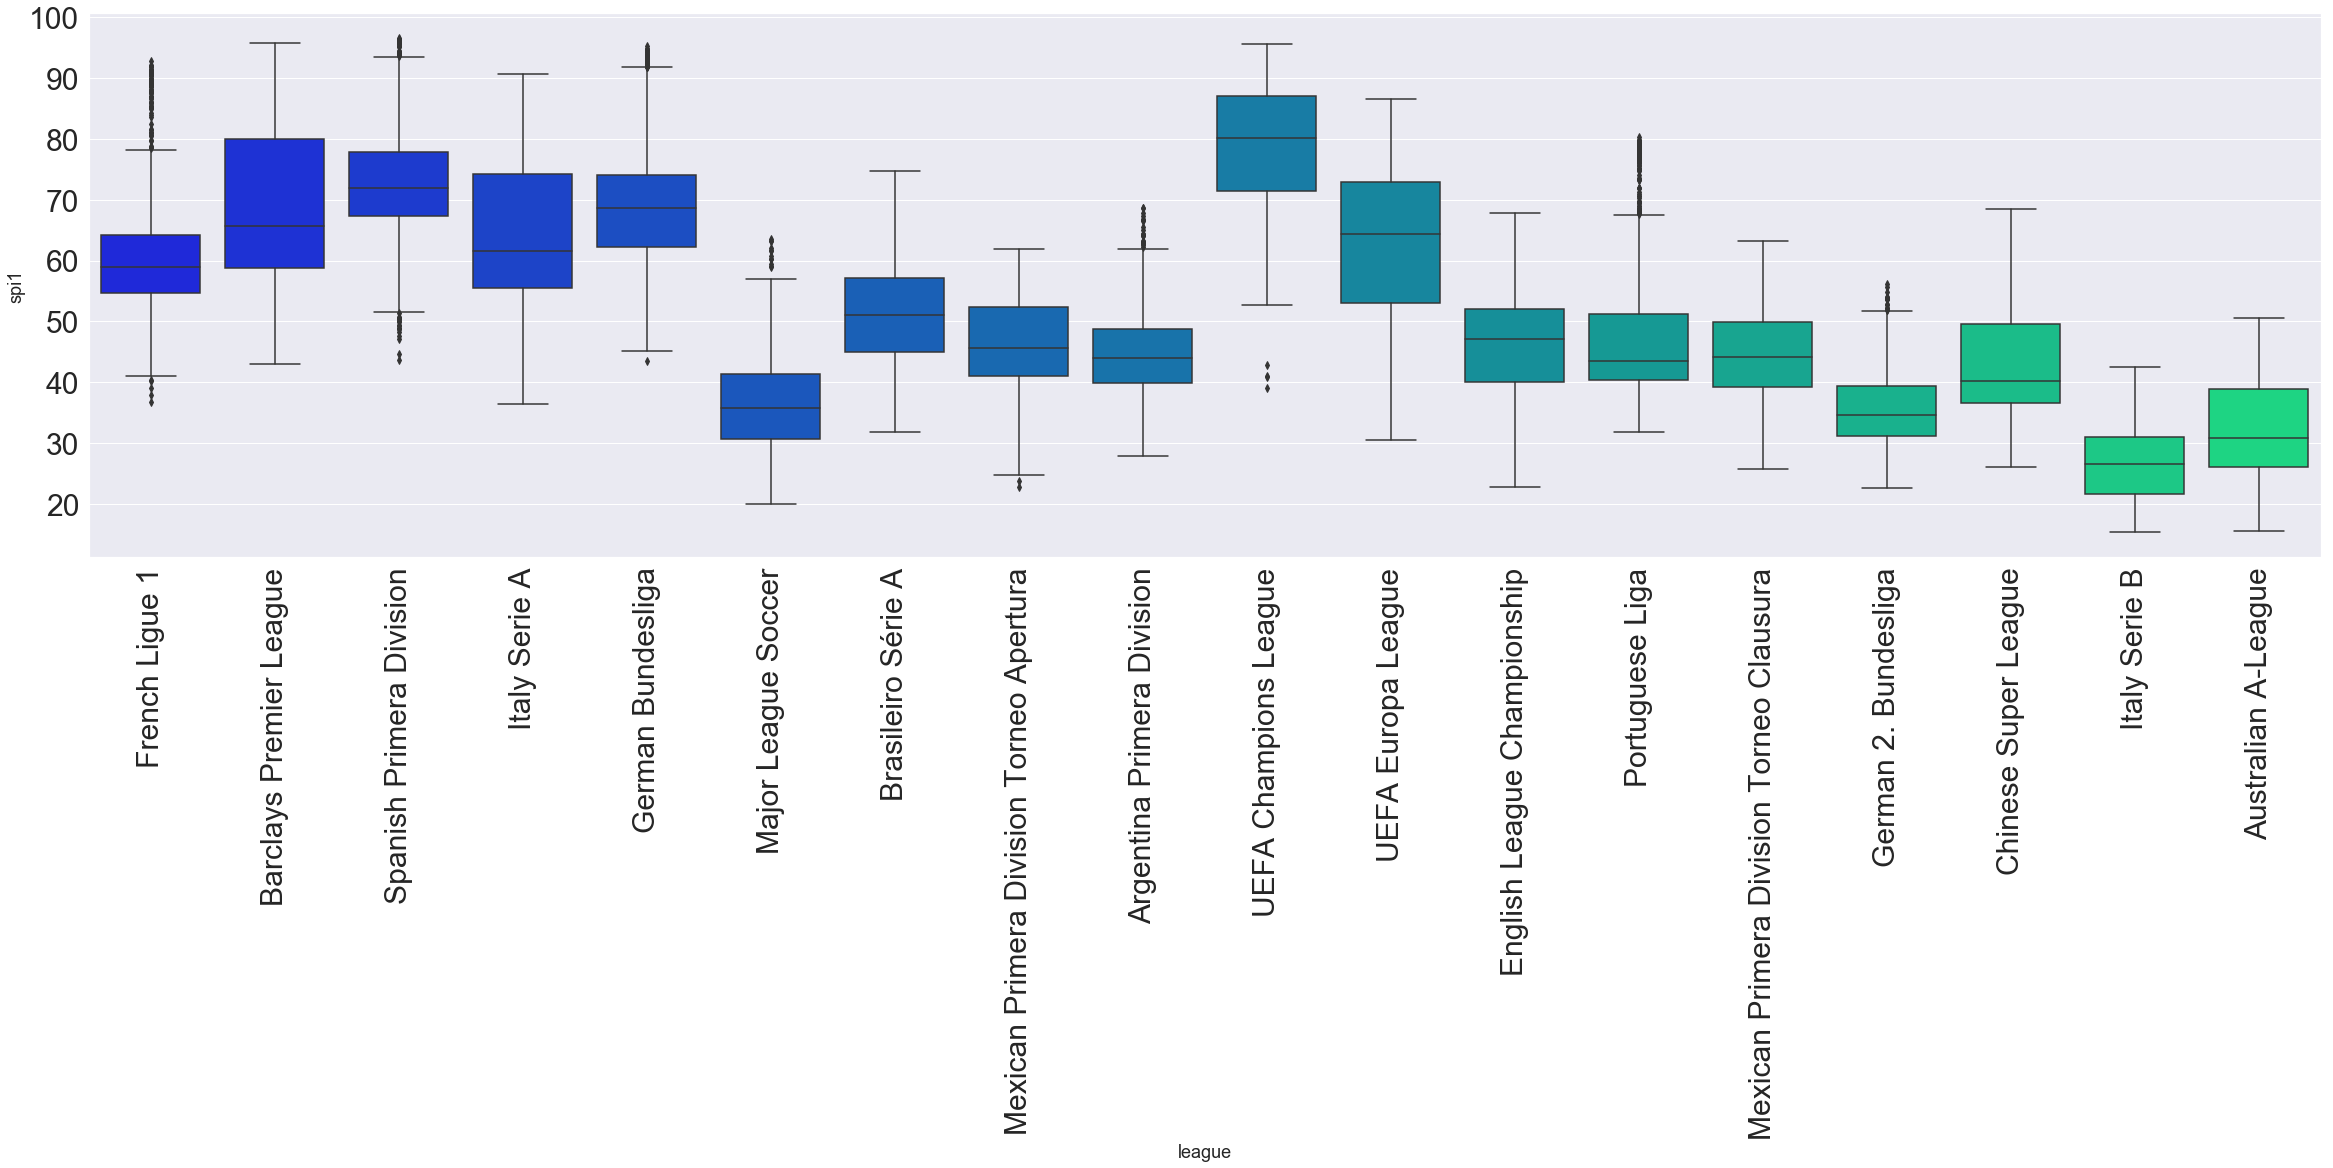

In [361]:
plt.figure(figsize=(40,10))
plt.xticks(size='30',rotation='vertical')
plt.yticks(size='30')
sns.boxplot(x='league',y='spi1',data=df,palette='winter',)

Here we are looking at the SPi1 ratings of each league. As we can see that Leagues from Weatern Europe, UEFA Champions league and UEFA Europa League have teams with very high spi1 ratings and also teams in A or first class divisions while others are not that high

Distributions of each Numerical Features is shown below where we can clearly see some variables following normalized variations with less skew meaning that variation in the data is very low

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024E6350E0F0>,
      dtype=object)

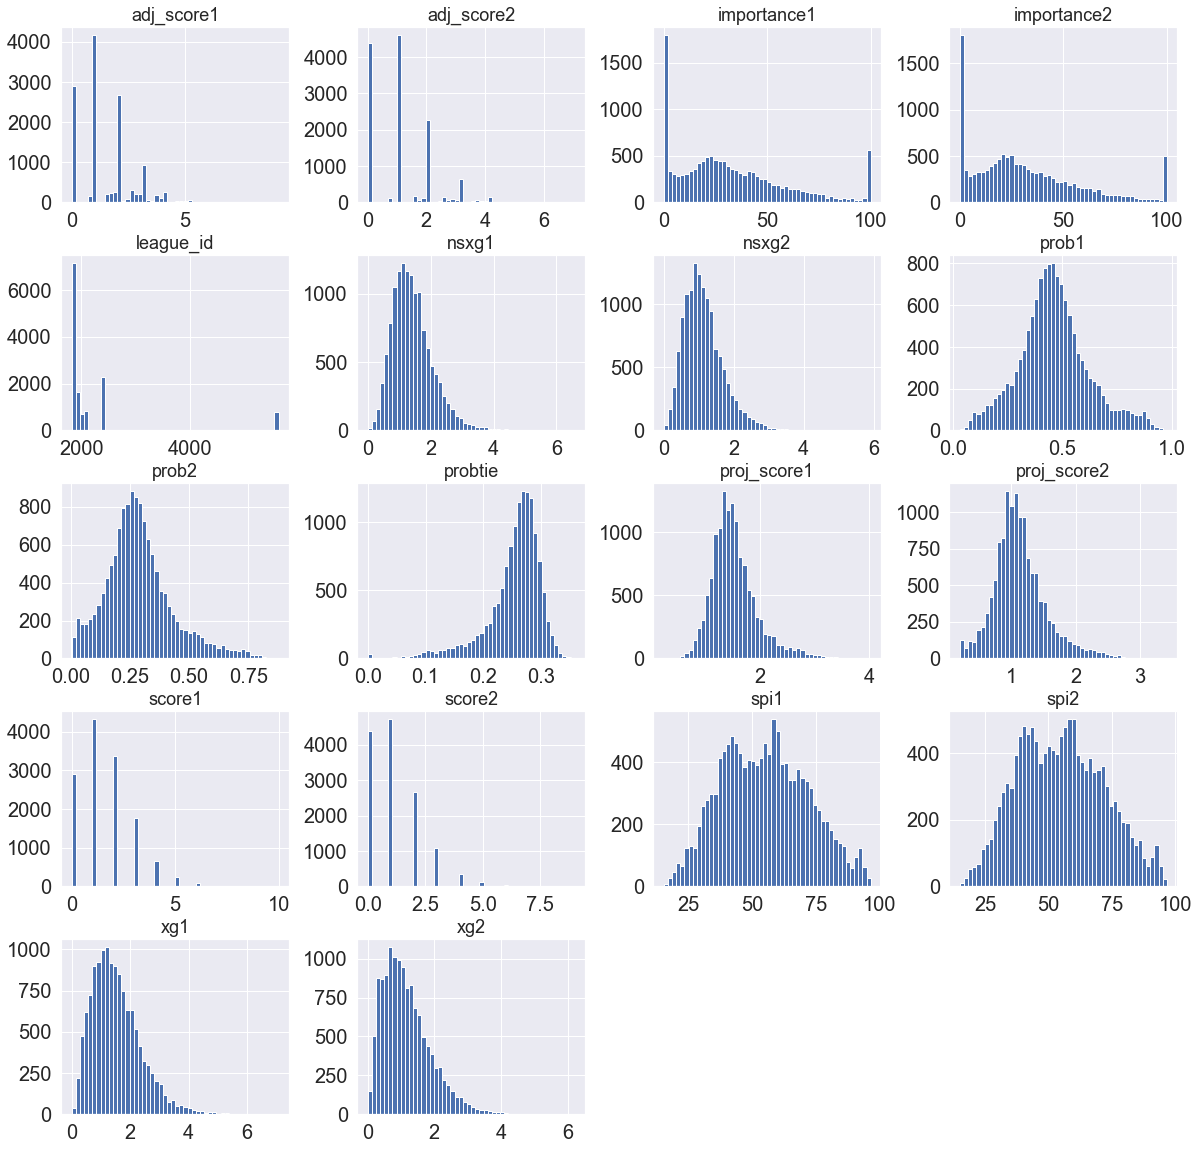

In [362]:
df.hist(figsize=(20,20),bins=50,xlabelsize=20,ylabelsize=20)

Now Lets plot the correlation matrix to check the dependencies of the features on each other and how variation in one changes the other.

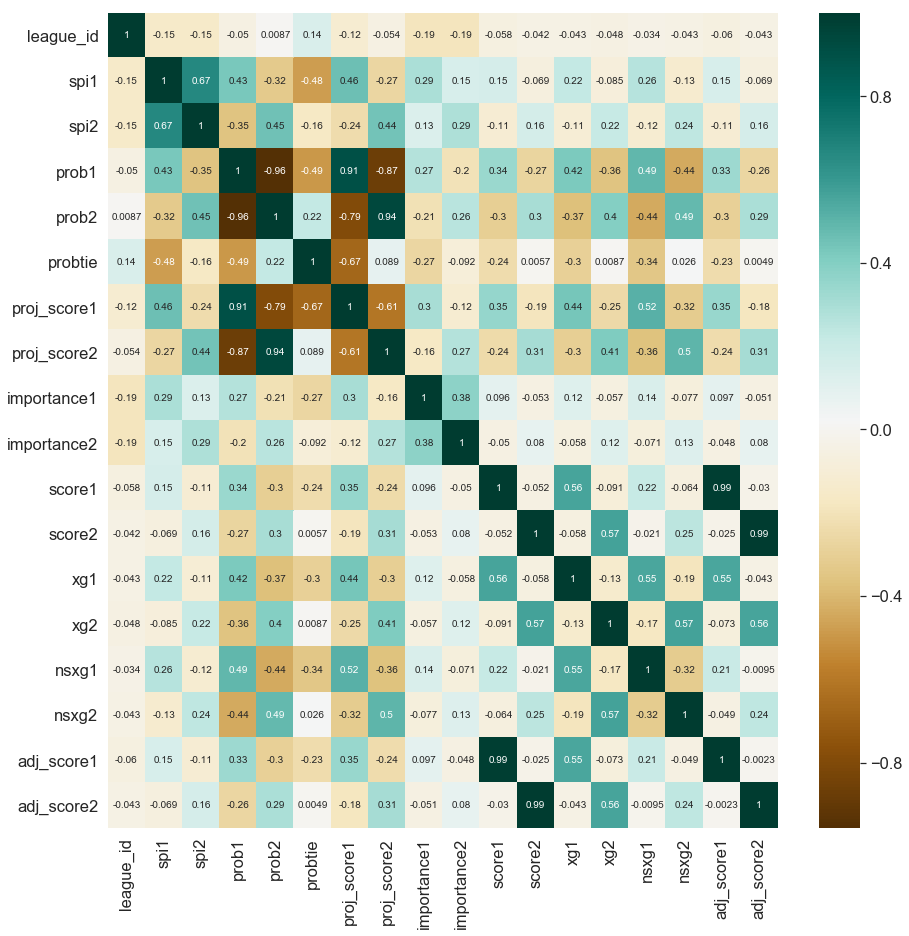

In [363]:
plt.figure(figsize=(15,15))
c= df.corr()
sns.heatmap(c,cmap='BrBG',annot=True,)

We can see that variables like Spi1, spi2, prob1, prob2 are closely related with scores and one another. Clearly if you have a high spi1 ratings it gives you more chance to score a goal. 

Now Lets plot the pair plots of the most important features found above to have a look at their distribution.

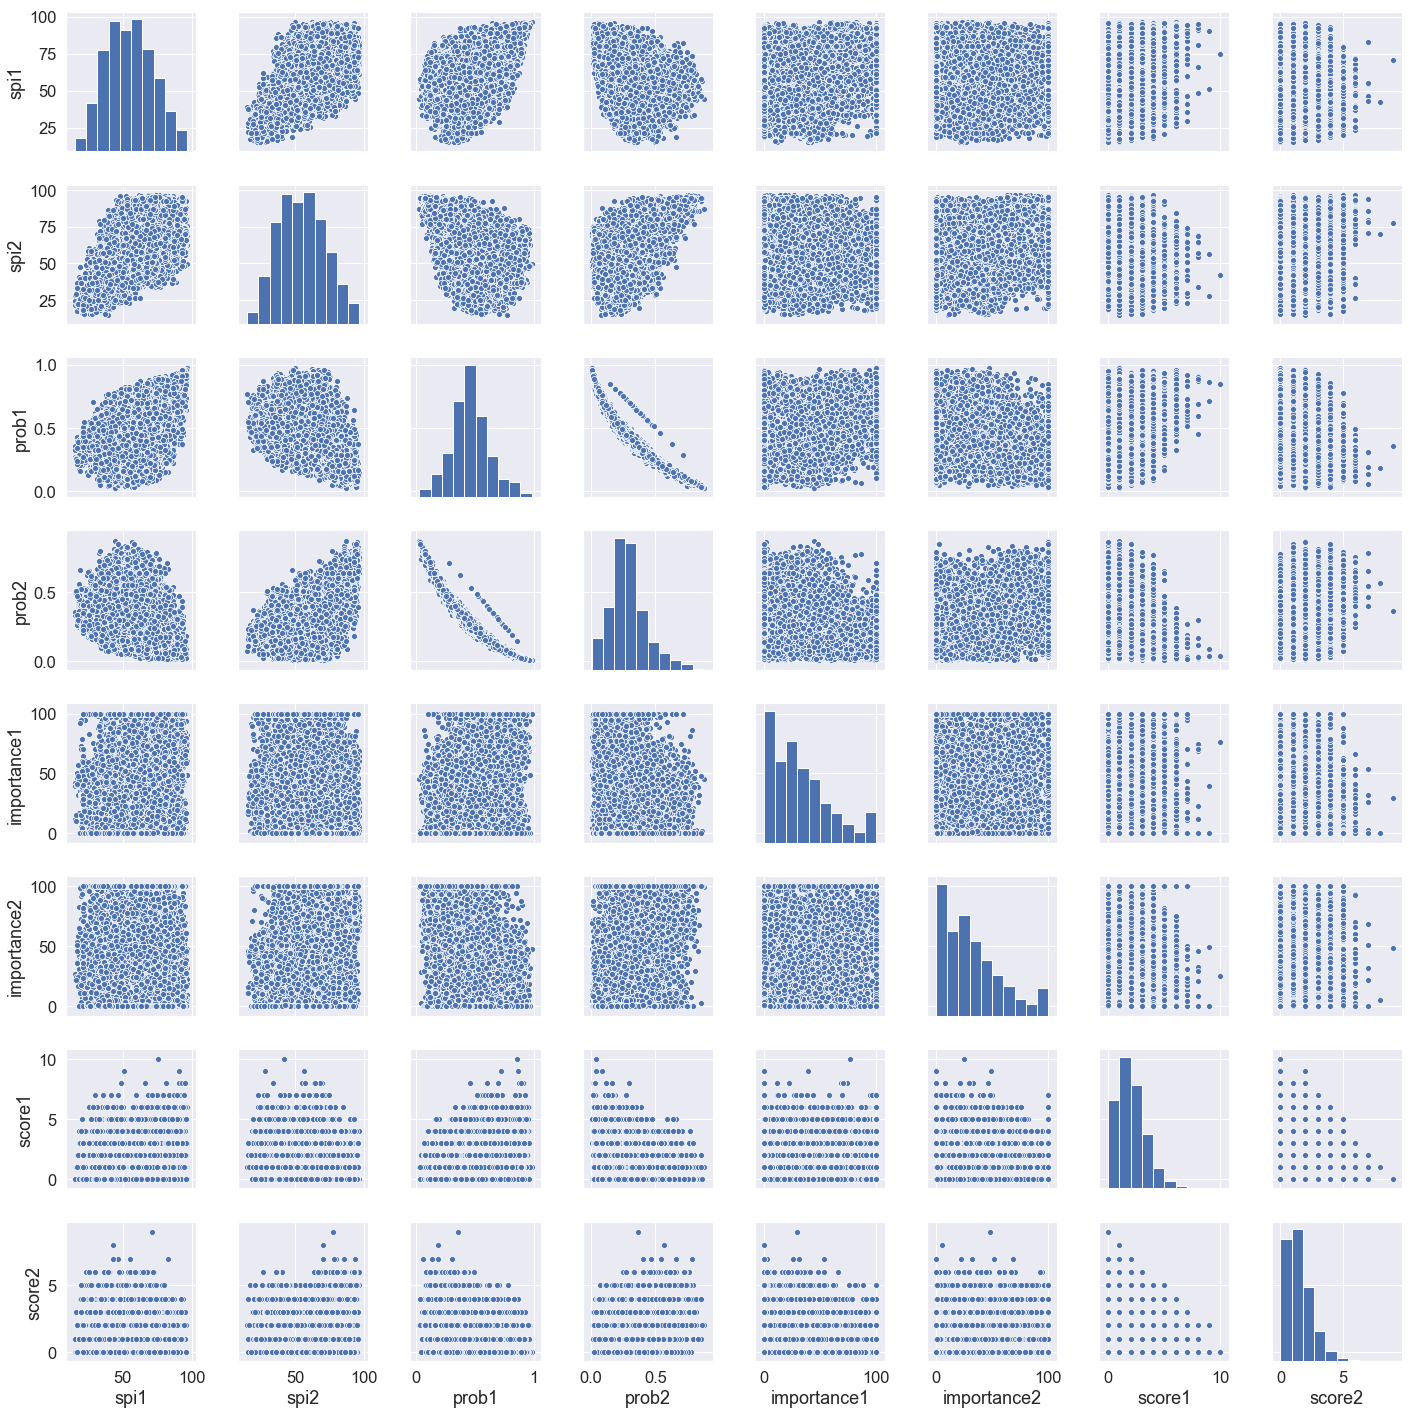

In [364]:
sns.set(font_scale=1.5)
sns.pairplot(df[['spi1','spi2','prob1','prob2','importance1','importance2','score1','score2']])

This graph shows that higher the probability, higher chance of scoring more than 1 goals. Higher the spi1 rating gives them the higher probabilities.

## 4. Data Preprocessing 

In [365]:
df.head(2)

,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,probtie,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
0,2016-08-12,1843,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,...,32.4,67.7,0.0,1.0,0.97,0.63,0.43,0.45,0.0,1.05
1,2016-08-12,1843,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,...,53.7,22.9,2.0,2.0,2.45,0.77,1.75,0.42,2.1,2.10


Now we are going to create dummy variables for all the ordinal & categorical variables so that we have all the data available for our model in the required format.

In [366]:
league_n=pd.get_dummies(df['league'],drop_first=True)
team1_n=pd.get_dummies(df['team1'],drop_first=True)
team1_columns=['team1_'+str(i) for i in team1_n.columns]
team1_n.columns=team1_columns
team2_n=pd.get_dummies(df['team2'],drop_first=True)
team2_columns=['team2_'+str(i) for i in team2_n.columns]
team2_n.columns=team2_columns
df1=pd.concat([df,league_n,team1_n,team2_n],axis=1)

Its good to have your data shffled so that all the data gets properly distributed between training and testing datasets.

In [367]:
from sklearn.utils import shuffle
df2=shuffle(df1).reset_index(drop=True)

In [368]:
X=df2.drop(['date','score1','league','team1','team2'],axis=1)
Y1=np.array(df2[['score1']])
Y2=np.array(df2['score2'])

We are going to normalize our data so that our model is able to work on it which is otherwise not possible

In [369]:
from sklearn import preprocessing
x=preprocessing.scale(X)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  


We are going to split our training and testing data.

In [370]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
X_train, X_test,Y_train, Y_test=train_test_split(x,Y1,test_size=0.1)

## 5. Linear Regression Model Design and Testing

In [371]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train,Y_train)
y_pred=model.predict(X_test)
print('Linear Regression model Accuracy is: '+str(model.score(X_test,Y_test)*100))

Linear Regression model Accuracy is: 98.16361120773463


In [372]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print('mean_absolute_error: '+str(mean_absolute_error(y_pred,Y_test)))
print('mean_squared_error: '+str(mean_squared_error(y_pred,Y_test)))
print('RMSE: '+str(np.sqrt(mean_squared_error(y_pred,Y_test))))

mean_absolute_error: 0.11743347439146046
mean_squared_error: 0.03299389176466845
RMSE: 0.1816422081033713


## 6. RandomForest Regressor to check Prediction

In [373]:
from sklearn.ensemble import RandomForestRegressor
RM=RandomForestRegressor(random_state=4)
RM.fit(X_train,Y_train)
y_pred=RM.predict(X_test)
RM.score(X_test,Y_test)
print('Random Forest Regressor model Accuracy is: '+str(RM.score(X_test,Y_test)*100))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Random Forest Regressor model Accuracy is: 99.38679960245057


In [374]:
print('mean_absolute_error: '+str(mean_absolute_error(y_pred,Y_test)))
print('mean_squared_error: '+str(mean_squared_error(y_pred,Y_test)))
print('RMSE: '+str(np.sqrt(mean_squared_error(y_pred,Y_test))))

mean_absolute_error: 0.016529543754674646
mean_squared_error: 0.011017202692595363
RMSE: 0.10496286339746722


## 7. Conclusion:

Accuracy, MAE, MSE and RMSE clearly indicates the model to be good one. Values are very low which tells us that difference between predicted and actual values is very low for both models.